In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

TEMPERATURE = 310*kelvin
FRICTION = 1/picosecond
TIMESTEP = 2*femtoseconds

SIGMA0 = (MOLAR_GAS_CONSTANT_R * TEMPERATURE ).value_in_unit(kilojoule_per_mole)

In [24]:
class CustomGaMDLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt, ktot, Etot, kgrp, Egrp, forceGroup):
        self.ktot = ktot 
        self.Etot = Etot 
        self.kgrp = kgrp
        self.Egrp = Egrp
        self.forceGroup = str(forceGroup)
        
        CustomIntegrator.__init__(self, dt)
            #lew added:
        self.addGlobalVariable("ktot", self.ktot)
        self.addGlobalVariable("Etot", self.Etot)
        self.addGlobalVariable("kgrp", self.ktot)
        self.addGlobalVariable("Egrp", self.Egrp)
        self.addGlobalVariable("groupEnergy", 0)
        
            #normal langevin:  
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
        
        self.addPerDofVariable("fgrp", 0)
        
            #normal langevin:                                                                  
        self.addUpdateContextState();
        
        self.addComputeGlobal("groupEnergy", "energy"+self.forceGroup)
        self.addComputePerDof("fgrp", "f"+self.forceGroup)
        
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original langevin line:                                                                                      
        #self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #GaMD:
        dof_string = "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);"
        dof_string+= "fprime= fprime1 + fprime2;"
        #fprime2 is the dihedral force modified by the boost. Boot calculated using group only. 
        dof_string+= "fprime2 = fgrp*((1-modifyGroup) + modifyGroup*((groupEnergy - (groupEnergy-Egrp)*kgrp)/groupEnergy)  );"
        #fprime1 is the other forces modified by the boost, but the boost is calculated using TOTAL energy. 
        dof_string+= "fprime1 = ftot*((1-modifyTotal) + modifyTotal*((energy - (energy-Etot )*ktot)/energy)  );" 
        dof_string+= "ftot=f-fgrp;"
        dof_string+= "modifyGroup=step(Egrp-groupEnergy);"
        dof_string+= "modifyTotal=step(Etot-energy);"


        self.addComputePerDof("v", dof_string); 
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        self.addComputePerDof("veloc", "v")
        
    def setKtot(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('ktot', newK)
        
    def setEtot(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Etot', newE)
        
    def setKgrp(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('kgrp', newK)
        
    def setEgrp(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Egrp', newE)
          
    def getGrpBoost(self, grpEnergy):
        kgrp = self.getGlobalVariableByName('kgrp')/kilojoules_per_mole
        Egrp = self.getGlobalVariableByName('Egrp')*kilojoules_per_mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        if (grpEnergy > Egrp):
            return 0*kilojoules_per_mole #no boosting
        return (kgrp * (grpEnergy-Egrp) ) # 'k' parameter should instead be per kj/mol
    
    def getTotBoost(self, totEnergy):
        ktot = self.getGlobalVariableByName('ktot')/kilojoules_per_mole
        Etot = self.getGlobalVariableByName('Etot')*kilojoules_per_mole
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if (totEnergy > Etot):
            return 0*kilojoules_per_mole #no boosting
        return ( ktot * (totEnergy-Etot) ) # 'k' parameter should instead be per kj/mol
        
    def getEffectiveEnergy(self, totEnergy, grpEnergy):
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        
        group_boost = self.getGrpBoost(grpEnergy)
        total_boost = self.getTotBoost(totEnergy)
        
        return totEnergy + group_boost + total_boost
        
 

In [25]:
def setup_system(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffPeriodic, constraints=HBonds,)
  system.addForce(MonteCarloBarostat(1*bar, 310*kelvin))
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb


def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    print(f.getForceGroup(), f.__class__)

def setup_simulation(system, pdb, integrator):
  """Creates a simulation object"""
  #platform = Platform.getPlatformByName('CPU')
  platform = Platform.getPlatformByName('OpenCL')
  prop = {'OpenCLPrecision':'single'}
  simulation = Simulation(pdb.topology, system, integrator, platform, prop)
  simulation.context.setPositions(pdb.positions)
  simulation.minimizeEnergy()
  simulation.context.setVelocitiesToTemperature(310*kelvin)
  print('Created simulation')
  return simulation



In [26]:
filename ='./alanine-dipeptide-explicit.pdb'
output_directory = './'


In [27]:
system, pdb = setup_system(filename)



Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
0 <class 'simtk.openmm.openmm.MonteCarloBarostat'>
Created system


In [28]:
integrator = CustomGaMDLangevinIntegrator(TEMPERATURE,
                                         FRICTION,
                                         TIMESTEP,
                                         0,
                                         -1e6*kilojoules_per_mole,
                                         0,
                                         -1e6*kilojoules_per_mole,
                                         2)

In [29]:
sim =setup_simulation(system, pdb, integrator)

Created simulation


In [30]:
def get_statistics(pe_trace, boost_trace=0):
    arr = np.array(pe_trace)
    arr = arr + np.array(boost_trace)
    Vmax = arr.max()
    Vmin = arr.min()
    Vavg = arr.mean()
    Vstd = np.std(arr)
    
    return [Vmax, Vmin, Vavg, Vstd]

def calc_parameters(Vmax, Vmin, Vavg, Vstd, mode='low', sigma_0=SIGMA0*10, verbose=False):
    E = Vmax
    k_0 = min(1, (sigma_0/Vstd) * ((Vmax-Vmin)/(Vmax-Vavg)))
    k = k_0 * (1 / (Vmax - Vmin) )
    
    if verbose:
        return E, k, k_0
    else:
        return E, k

# Collect some statistics from cMD:

In [31]:
grp_nrgs = list()
tot_nrgs = list()


for i in tqdm.tqdm_notebook(range(2000)):
    sim.step(75)
    
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoule_per_mole
    tot_nrg = sim.context.getState(getEnergy=True).getPotentialEnergy()/kilojoule_per_mole
    
    grp_nrgs.append(grp_nrg)
    tot_nrgs.append(tot_nrg)
    
    

In [32]:
Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs,0)
E = Vavg

k=0.5
#E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*10)
sim.integrator.setEtot(E)
sim.integrator.setKtot(k)

Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, 0)
E = Vavg
k=0.5
#E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*3)
sim.integrator.setEgrp(E)
sim.integrator.setKgrp(k)

In [33]:
grp_nrgs = list()
tot_nrgs = list()

grp_boosts = list()
tot_boosts = list()

ks = list()
k_0s = list()
vmaxs = list()

gks = list()
gk_0s = list()
gvmaxs = list()

for _ in range(10):
    #equil:
    sim.step(10000)
    
    for i in tqdm.tqdm_notebook(range(500)):
        sim.step(500)
        
        grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
        tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
        
        grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
        tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
        grp_boosts.append(grp_boost)
        tot_boosts.append(tot_boost)
        
        grp_nrgs.append(grp_nrg)
        tot_nrgs.append(tot_nrg)
        
    Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs)
    #E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*10,verbose=True)
    sim.integrator.setEtot(Vavg)
    #sim.integrator.setKtot(k)
    
    #ks.append(k)
    #k_0s.append(k_0)
    vmaxs.append(Vavg)
    print(Vavg)

    #smaller SIGMA0 for dihedrals group:
    Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs)
    #E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*3, verbose=True)
    sim.integrator.setEgrp(Vavg)
    #sim.integrator.setKgrp(k)
    
    #gks.append(k)
    #gk_0s.append(k_0)
    gvmaxs.append(Vavg)
    print(Vavg)

    


-29435.152945880756
48.22118858337402



-29425.313738455756
48.19675139999389



-29429.07798986889
48.363804801940915



-29430.655743447176
48.30803447532654



-29433.454154887462
48.35246909027099


KeyboardInterrupt: 

In [34]:
_=plt.hist(energy,bins=100
        )

NameError: name 'energy' is not defined

In [35]:
plt.figure(figsize=(10,10))
diff = energy.mean()-0
_=plt.hist((energy-diff) * np.abs((energy- diff)*0.1),bins=100)

NameError: name 'energy' is not defined

<Figure size 720x720 with 0 Axes>

In [65]:
print('hi')

hi


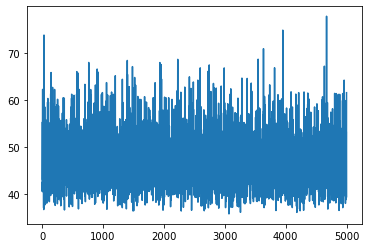

In [37]:
energy = np.array(grp_nrgs)
threshold = np.mean(energy)
plt.plot(energy)


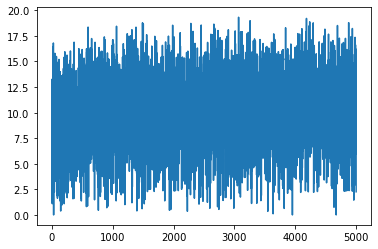

In [26]:
plt.plot(grp_boosts)

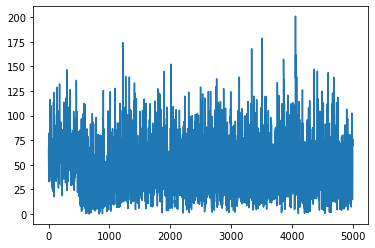

In [27]:
plt.plot(tot_boosts)

<AxesSubplot:>

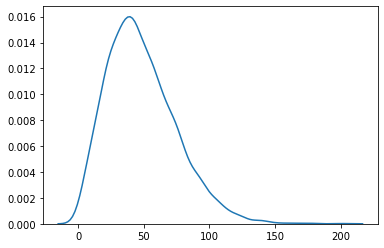

In [30]:
from seaborn import kdeplot
kdeplot(tot_boosts[1000:])

<AxesSubplot:>

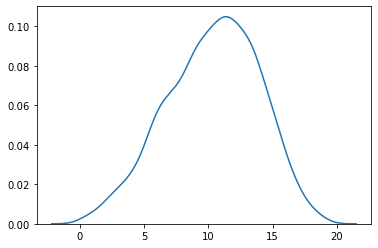

In [31]:
kdeplot(grp_boosts[1000:])

# Add a trajectory reporter and do some production run:

In [38]:

sim.reporters.append(DCDReporter('diala_gamd_traj.dcd', 2500))

In [39]:
production = dict()
production['grp_nrgs'] = list()
production['tot_nrgs'] = list()

production['grp_boosts'] = list()
production['tot_boosts'] = list()

def report(sim, prod):
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
    tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
        
    grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
    tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
    prod['grp_boosts'].append(grp_boost)
    prod['tot_boosts'].append(tot_boost)
        
    prod['grp_nrgs'].append(grp_nrg)
    prod['tot_nrgs'].append(tot_nrg)
    

In [ ]:
for _ in tqdm.tqdm_notebook(range(6000)):
    report(sim, production)
    if _ % 5 == 0:
        sim.integrator.setGlobalVariableByName('Egrp', np.mean(production['grp_nrgs']))
        sim.integrator.setGlobalVariableByName('Etot', np.mean(production['tot_nrgs']))
    
    
    sim.step(2500)

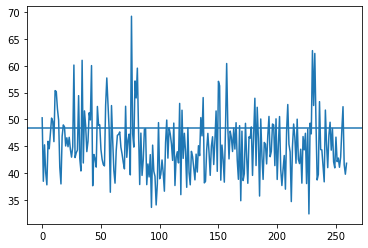

In [44]:
plt.plot(production['grp_nrgs'])
plt.axhline(sim.integrator.getGlobalVariableByName('Egrp'))

In [46]:
import mdtraj as md

In [50]:
##the dihedral idices:
indices = np.array([[4, 6, 8, 14],[6, 8, 14, 16]])

In [51]:
traj = md.load_dcd('./diala_gamd_traj.dcd', top='./alanine-dipeptide-explicit.pdb')

In [52]:
dihedrals = md.compute_dihedrals(traj, indices, periodic=True)

In [25]:
plt.scatter(dihedrals[:,1], dihedrals[:,0])

NameError: name 'dihedrals' is not defined

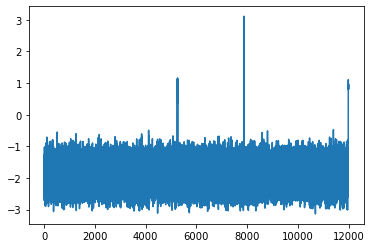

In [54]:
plt.plot(dihedrals[:,0])

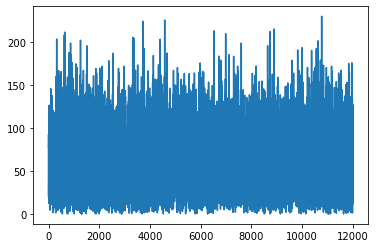

In [55]:
#plt.plot(np.array(production['tot_nrgs']))
plt.plot(np.array(production['tot_boosts']))

<AxesSubplot:>

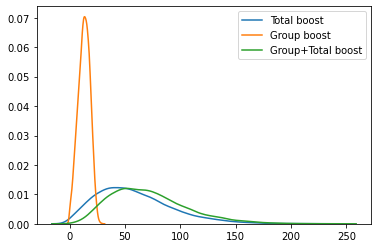

In [56]:
kdeplot(np.array(production['tot_boosts']), label='Total boost')
kdeplot(np.array(production['grp_boosts']), label='Group boost')

kdeplot(np.array(production['grp_boosts'])+np.array(production['tot_boosts']), label='Group+Total boost')

In [57]:
as_kcal = (np.array(production['grp_boosts'])+np.array(production['tot_boosts']))*kilojoules_per_mole
as_kcal = as_kcal.value_in_unit(kilocalories_per_mole)

In [44]:
count = 0
f = open('weights.dat', 'w')
for item in as_kcal:
    line = str(item/0.6) + ' ' + str(count) + ' ' + str(item) + '\n'
    f.write(line+'\n')
    count+=50
f.close()

In [59]:
np.std(as_kcal)

8.254583373349266

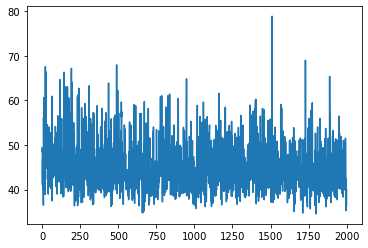

In [41]:
plt.plot(grp_nrgs)

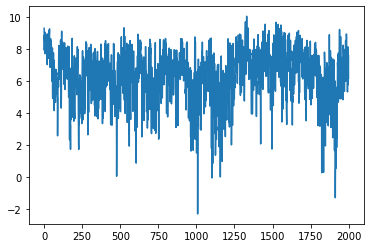

In [79]:
plt.plot((70-np.array(grp_nrgs))*0.3)

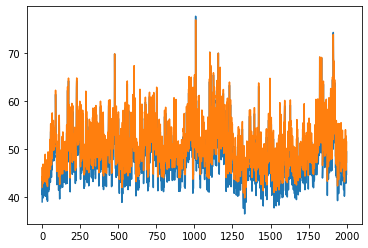

In [85]:
plt.plot(np.array(grp_nrgs))
plt.plot(np.array(grp_nrgs) + (70-np.array(grp_nrgs))*0.1)

<AxesSubplot:>

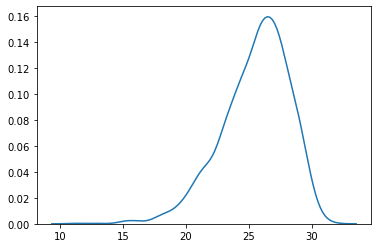

In [89]:
kdeplot((100-np.array(grp_nrgs))*0.5)

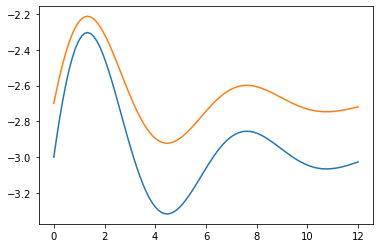

In [83]:
import numpy as np
import matplotlib.pyplot as plt

xa = np.linspace(0, 12, 100)
ya = np.sin(xa)*np.exp(-xa/4)-3



plt.plot(xa, ya)

plt.plot(xa, ya + (-2.-ya)*0.3)

In [93]:
(ya + (-2.-ya)*0.3)/ ya

array([0.9       , 0.90813866, 0.91628947, 0.92427955, 0.93191723,
       0.93900063, 0.94532934, 0.95071832, 0.95501232, 0.95809884,
       0.95991756, 0.96046459, 0.9597911 , 0.95799645, 0.95521753,
       0.95161584, 0.94736454, 0.94263678, 0.93759654, 0.93239213,
       0.92715257, 0.92198604, 0.91698027, 0.91220394, 0.90770885,
       0.90353231, 0.8996996 , 0.89622623, 0.89311994, 0.89038246,
       0.88801089, 0.88599885, 0.88433734, 0.88301543, 0.88202073,
       0.8813397 , 0.88095786, 0.88085992, 0.88102978, 0.88145052,
       0.88210437, 0.88297259, 0.88403544, 0.88527208, 0.88666054,
       0.8881777 , 0.88979937, 0.89150038, 0.89325474, 0.89503593,
       0.89681718, 0.89857187, 0.90027402, 0.90189873, 0.90342272,
       0.90482486, 0.90608661, 0.90719251, 0.90813047, 0.90889205,
       0.90947259, 0.90987118, 0.91009058, 0.91013696, 0.91001957,
       0.90975033, 0.90934335, 0.90881444, 0.90818061, 0.90745955,
       0.90666922, 0.90582739, 0.90495132, 0.90405743, 0.90316

In [94]:
0.7 / 2

0.35

In [95]:
2*0.35

0.7

<AxesSubplot:>

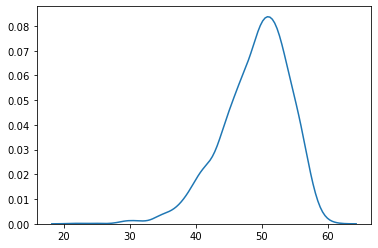

In [74]:
kdeplot((100-np.array(grp_nrgs))**0.99)

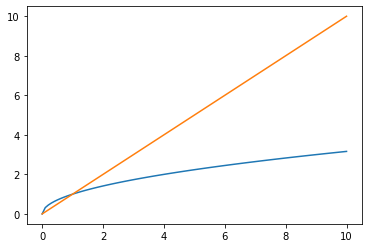

In [59]:
x = np.linspace(0,10,100)
y = np.sqrt(x)
y2 = x
plt.plot(x,y)
plt.plot(x,x)